# Access AODN Ocean Colour Chl-OC3  data from AWS S3 bucket with Xarray

|  |  |
| ----------- | ----------- |
| Author:| Laurent Besnard |
| Edited:| Benjamin Stepin |
| Affiliation:| IMOS |
| e-mail:| info@aodn.org.au |
| Date of creation:| 5th May., 2021 |
| Date of last update:| 21st May., 2024 |


## Table of Contents
### [Background](#background)
### [Required Packages](#required-packages)

1. [Mount S3 bucket as a filesystem in Python](#1-mount-s3-bucket-as-a-filesystem-in-python)
2. [Chl Oc3 dataset - load multiple NetCDF files into and Xarray dataset](#2-chl-oc3-dataset---load-multiple-netcdf-files-into-and-xarray-dataset)
3. [Understanding the Dataset](#3-understanding-the-dataset)
4. [Chl Oc3 - Plot of a timeseries](#4-chl-oc3---plot-of-a-timeseries)
5. [Chl Oc3 - Plot the gridded dataset and subset](#5-chl-oc3---plot-the-gridded-dataset-and-subset)
6. [Exercise - Sea Surface Temperature product](#6-exercise---sea-surface-temperature-product)
   - [I. Locate the NetCDF files](#i-locate-the-netcdf-files)
   - [II. Understand the content of the Xarray dataset](#ii-understand-the-content-of-the-xarray-dataset)
   - [III. Plot the data](#iii-plot-the-data)

<a id="Background"></a>
## Background

Most of AODN data is stored on Amazon Web Services S3 object storage [AWS S3](http://data.aodn.org.au/).

In the following Notebook, we will make use of the AWS S3 bucket to mount it  as a filesystem in Python allowing the access to NetCDF files.

We also will use ```xarray.open_mfdataset``` ([Xarray](http://xarray.pydata.org/en/stable/)) to combine many, similary structured, NetCDF files. This enables easy queries to be performed on a dataset.

In this example, the IMOS Aqua Chlorophyll **Chl-OC3** product will be used:
 * https://portal.aodn.org.au/search?uuid=d7a14921-8f3f-4522-9a54-e7d1df969c8a
 * http://thredds.aodn.org.au/thredds/catalog/IMOS/SRS/OC/gridded/aqua/P1D/catalog.html
 * http://imos-data.s3-website-ap-southeast-2.amazonaws.com/?prefix=IMOS/SRS/OC/gridded/aqua/P1D/


### Chl-OC3 dataset:
The Aqua satellite platform carries a MODIS sensor that observes sunlight reflected from within the ocean surface layer at multiple wavelengths. These multi-spectral measurements are used to infer the concentration of chlorophyll-a (Chl-a), most typically due to phytoplankton, present in the water.

The data are produced from the near real time (nrt) data stream formed by combining data from all the available direct broadcast reception stations in Australia (Alice Springs, Melbourne, Townsville, Perth, Hobart) supplemented by delayed-mode data from NASA in the US. The granules have been remapped from satellite projection into a geographic (Latitude/Longitude axes) projection and are presented as a sequence of daily mosaics covering the region (80 <= Longitude <= 180, -60 <= Latitude <= +10) formatted as CF-compliant netCDF files. It should be noted that the data are not processed until the definitive spacecraft ephemeris becomes available, usually 12-24 hours after the overpass. This means that the geolocation should be of a uniformly high standard.

There are multiple retrieval algorithms for estimating Chl-a. These data use the OC3 method recommended by the NASA Ocean Biology Processing Group and implemented in the SeaDAS processing software l2gen. The OC3 algorithm is described at http://oceancolor.gsfc.nasa.gov/cms/atbd/chlor_a (and links therein). The radiometric sensitivity of the MODIS sensor is evolving continuously during its mission and is monitored regularly by NASA. The SeaDAS software uses tables of calibration coefficients that are updated periodically. From time to time upgrades to the algorithms and/or the format of the calibration tables are required, in which case a new version of SeaDAS is released. These data were initially being produced using SeaDAS 6.4 and more recently, with SeaDAS 7.x.

## Required packages

- intake
- s3fs
- h5netcdf
- xarray
- cftime
- cmocean
- dask

In [ ]:
# Run the following to install the packages
# !pip install intake s3fs h5netcdf xarray cftime cmocean dask

<a id="Mount"></a>
## 1. Mount S3 bucket as a filesystem in Python

In [1]:
import intake
import s3fs
import os
import cftime
import cmocean

import cmocean.cm as cmo
import xarray as xr

In [2]:
# Mount the S3 bucket as a FS
fs = s3fs.S3FileSystem(anon=True)

# IMOS S3 bucket prefix
imos_s3_bucket_prefix = 'imos-data'
data_dir = 'IMOS/SRS/OC/gridded/aqua/P1D/2021/01'
s3_data_dir = f'{imos_s3_bucket_prefix}/{data_dir}'  
# Walk through the S3 directory
fs_data_files = fs.walk(s3_data_dir)

# Get only the filenames from the data structure
fs_data_files = [k for k in fs_data_files][0][2]

# List all the different Ocean Colour products created daily
fs_data_files[0:5], fs_data_files[-5:]


(['A.P1D.20210101T053000Z.aust.K_490.nc',
  'A.P1D.20210101T053000Z.aust.chl_carder.nc',
  'A.P1D.20210101T053000Z.aust.chl_gsm.nc',
  'A.P1D.20210101T053000Z.aust.chl_oc3.nc',
  'A.P1D.20210101T053000Z.aust.chl_oci.nc'],
 ['A.P1D.20210131T053000Z.aust.par.nc',
  'A.P1D.20210131T053000Z.aust.picop_brewin2010at.nc',
  'A.P1D.20210131T053000Z.aust.picop_brewin2012in.nc',
  'A.P1D.20210131T053000Z.aust.sst.nc',
  'A.P1D.20210131T053000Z.aust.sst_quality.nc'])

<a id="LoadMulti"></a>
## 2. Chl Oc3 dataset - load multiple NetCDF files into and Xarray dataset

In [3]:
data_files_chl_oc3 = [k for k in fs_data_files if 'chl_oc3' in k]
data_files_chl_oc3[0:5], data_files_chl_oc3[-5:]

(['A.P1D.20210101T053000Z.aust.chl_oc3.nc',
  'A.P1D.20210102T053000Z.aust.chl_oc3.nc',
  'A.P1D.20210103T053000Z.aust.chl_oc3.nc',
  'A.P1D.20210104T053000Z.aust.chl_oc3.nc',
  'A.P1D.20210105T053000Z.aust.chl_oc3.nc'],
 ['A.P1D.20210127T053000Z.aust.chl_oc3.nc',
  'A.P1D.20210128T053000Z.aust.chl_oc3.nc',
  'A.P1D.20210129T053000Z.aust.chl_oc3.nc',
  'A.P1D.20210130T053000Z.aust.chl_oc3.nc',
  'A.P1D.20210131T053000Z.aust.chl_oc3.nc'])

In [4]:
# Open multiple files using xarray, accessing files from S3 bucket
n_files = 20
file_handles = [fs.open(s3_data_dir + '/' + filename) for filename in data_files_chl_oc3[:n_files]]
ds_multi = xr.open_mfdataset(file_handles, engine='h5netcdf', combine='by_coords')

<a id="Understanding"></a>
## 3. Understanding the Dataset

In [5]:
print(ds_multi)

<xarray.Dataset> Size: 6GB
Dimensions:    (time: 20, latitude: 7001, longitude: 10001)
Coordinates:
  * time       (time) datetime64[ns] 160B 2021-01-01T05:30:00 ... 2021-01-20T...
  * latitude   (latitude) float64 56kB 10.0 9.99 9.98 ... -59.98 -59.99 -60.0
  * longitude  (longitude) float64 80kB 80.0 80.01 80.02 ... 180.0 180.0 180.0
Data variables:
    chl_oc3    (time, latitude, longitude) float32 6GB dask.array<chunksize=(1, 1401, 2001), meta=np.ndarray>
Attributes:
    history:      File initialised at 2021-01-18T17:21:07.559582\nInitialised...
    Conventions:  CF-1.6
    source_path:  imos-srs/archive/oc/aqua/v201909/1d/2021/01/A20210101.L2OC_...


In [6]:
print(ds_multi.chl_oc3)

<xarray.DataArray 'chl_oc3' (time: 20, latitude: 7001, longitude: 10001)> Size: 6GB
dask.array<concatenate, shape=(20, 7001, 10001), dtype=float32, chunksize=(1, 1401, 2001), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 160B 2021-01-01T05:30:00 ... 2021-01-20T...
  * latitude   (latitude) float64 56kB 10.0 9.99 9.98 ... -59.98 -59.99 -60.0
  * longitude  (longitude) float64 80kB 80.0 80.01 80.02 ... 180.0 180.0 180.0
Attributes:
    units:         mg/m^3
    long_name:     Chlorophyll Concentration, OC3 Algorithm
    flag_applied:  HISATZEN LAND CLDICE NAVFAIL


In [7]:
print(ds_multi.chl_oc3.units)

mg/m^3


<a id="PlotTS"></a>
## 4. Chl Oc3 - Plot of a timeseries

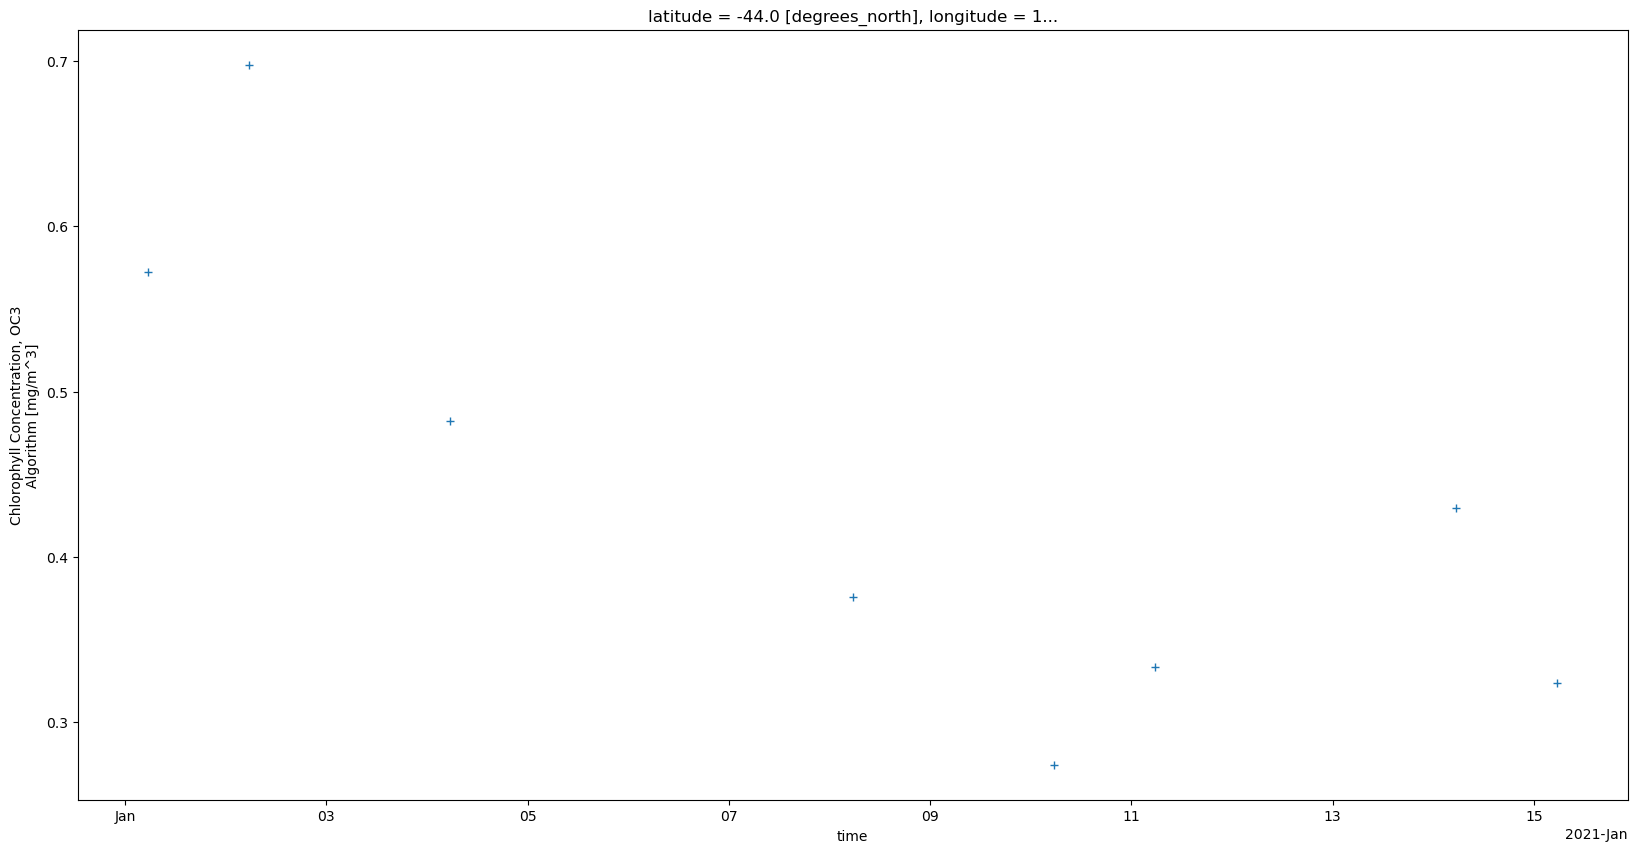

In [8]:
ds_multi.chl_oc3.sel(latitude=-44, longitude=150.5, method='nearest').plot(marker='+',markerfacecolor='None', linestyle="None", figsize=(20,10))

<a id="PlotGrid"></a>
## 5. Chl Oc3 - Plot the gridded dataset and subset

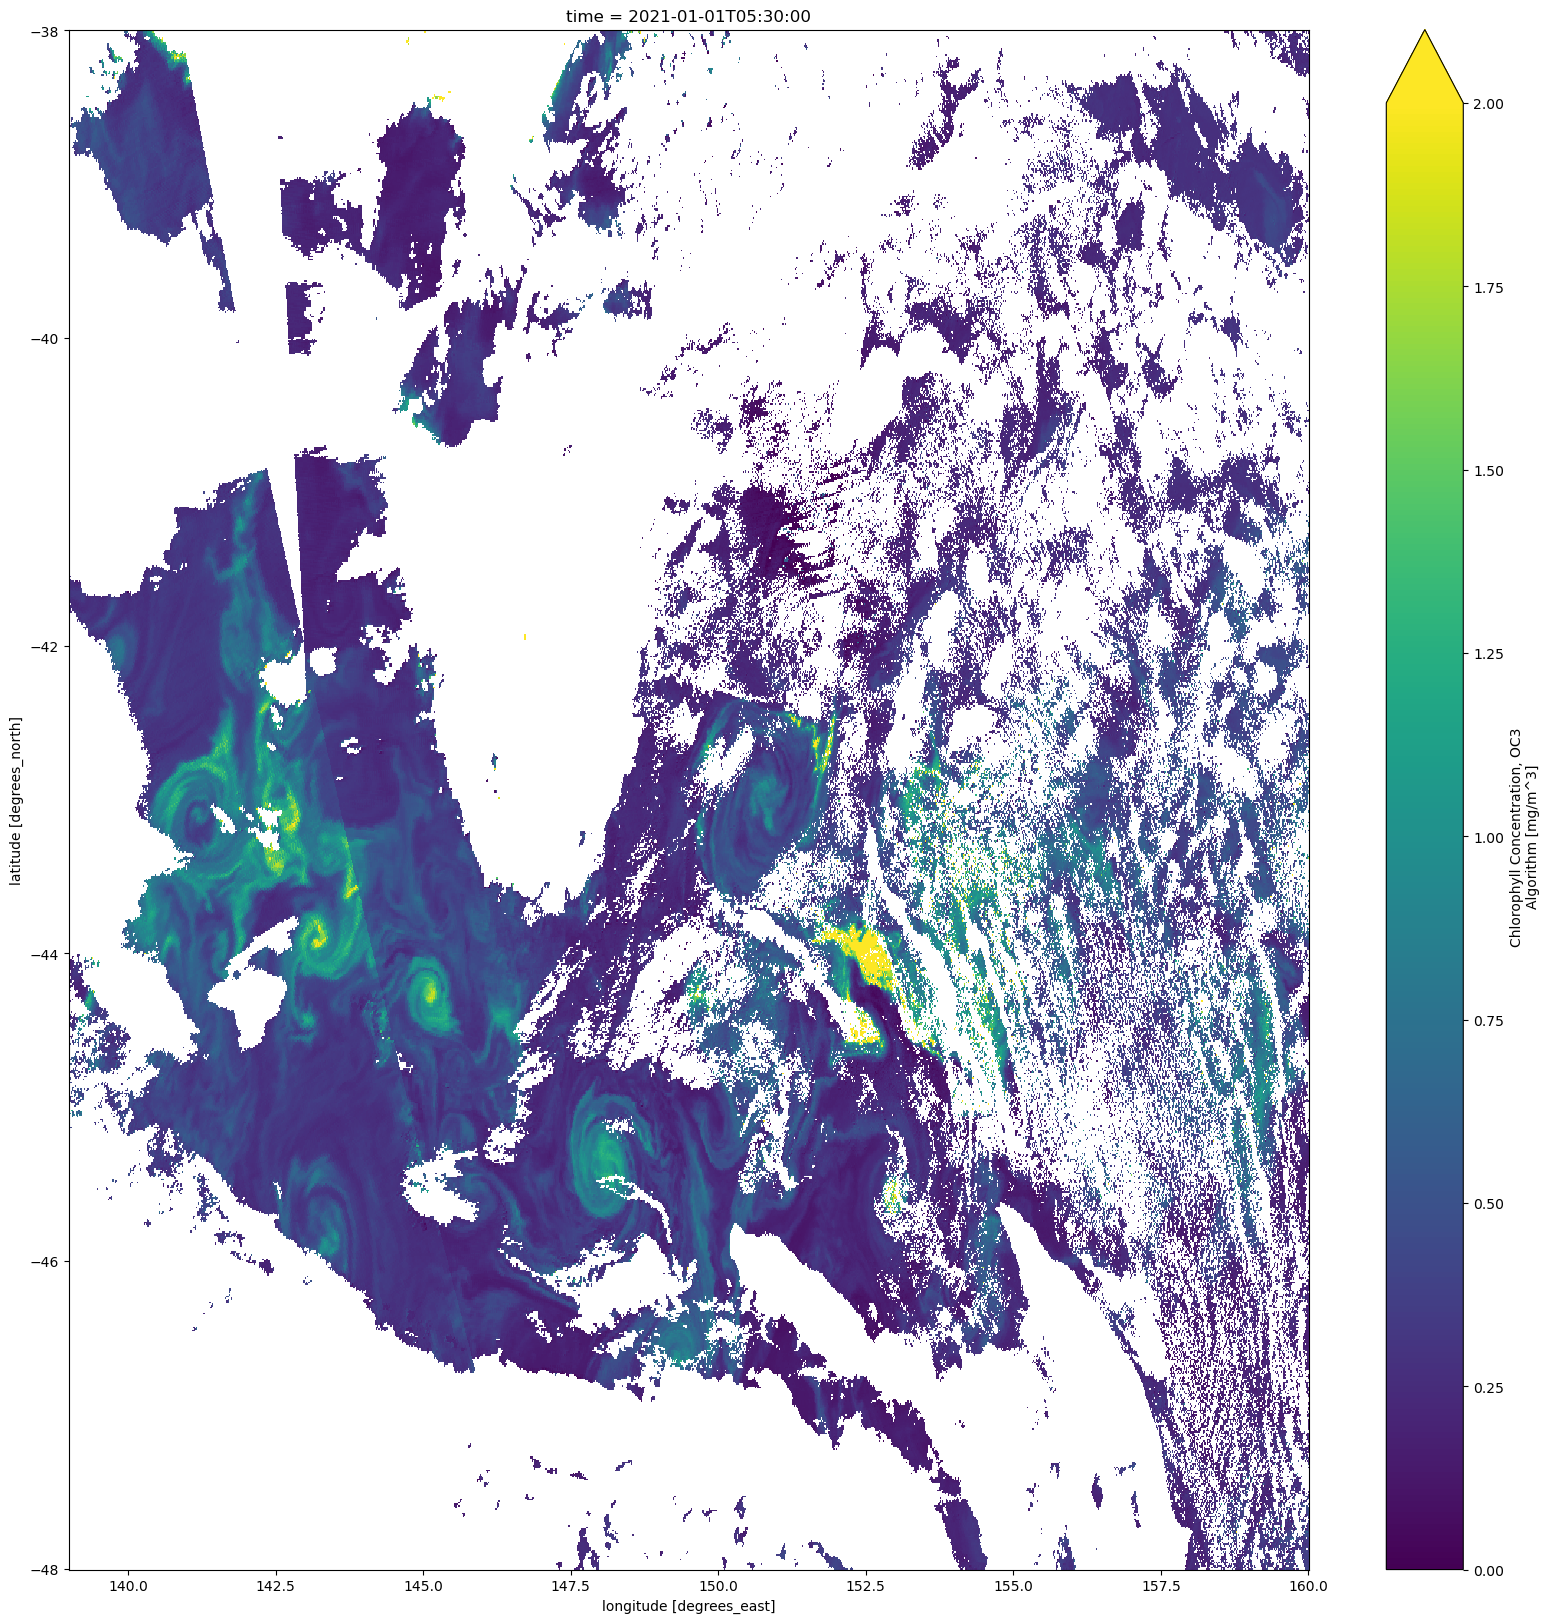

In [9]:
ds_multi.chl_oc3.sel(time='2021-01-01T05:30:00', latitude=slice(-38,-48), longitude=slice(139, 160)).plot(vmin=0, vmax=2, figsize=(20,20))

<a id="Exercise"></a>
## 6. Exercise - Sea Surface Temperature product

In the following exercice, we will use the ```L3SM-6d dn``` Sea Surface Temperature (SST) product
 * **L3**: Level 3 product Multiple pass, Multiple satellite
 * **M**: Multisensor 
 * **6d**: 6 day composite
 * **dn**: day and night

For more information of the different SST products, see:
 * https://help.aodn.org.au/satellite-data-product-information/
 * https://help.aodn.org.au/product-categories/


The data is directly accessible here:
http://imos-data.s3-website-ap-southeast-2.amazonaws.com/?prefix=IMOS/SRS/SST/ghrsst/L3SM-6d/dn/2021/

<a id="Locate"></a>
### I. Locate the NetCDF files
In the following Cell, write the correct value of ```data_dir``` variable where the NetCDF files of the ```L3M-6d dn``` product are stored/visible.

In [ ]:
# TODO: write the correct ```data_dir``` value 

imos_s3_bucket_prefix = 'imos-data'
data_dir = 'IMOS/SRS/SST/FOLDER_NAME_TO_EDIT' # eg 'IMOS/SRS/SST/ghrsst/L3SM-6d/dn/2024'
s3_data_dir = f'{imos_s3_bucket_prefix}/{data_dir}'  

In [ ]:
fs = s3fs.S3FileSystem(anon=True)  ## mount the S3 bucket as a FS

# imos S3 bucket starts with imos-data
try:
    # List the contents of the directory
    fs_data_files_list = fs.ls(s3_data_dir)
    print("fs_data_files_list:", fs_data_files_list)

    # Extract the filenames
    fs_data_files = [file for file in fs_data_files_list if not file.endswith('/')]
    print("fs_data_files:", fs_data_files)

    n_files = 10

    # Check if there are enough files
    if len(fs_data_files) < n_files:
        raise IndexError(f"Not enough files in the directory. Found {len(fs_data_files)} files.")

    file_handles = [fs.open(file) for file in fs_data_files[:n_files]]
    ds_multi = xr.open_mfdataset(file_handles, engine='h5netcdf', combine='by_coords')
    print("Successfully opened datasets.")
except Exception as e:
    print(f"Error: {e}")


<a id="UnderstandXR"></a>
### II. Understand the content of the Xarray dataset

```ds_multi``` should contain now many NetCDF files. 

In the next part, investigate the content of the xarray dataset, the dimensions, global attributes .... and write into the variable ```variable_name``` the string of the Sea Surface Temperature variable to plot.

In [ ]:
print(ds_multi.title)
print(ds_multi.summary)

In [ ]:
ds_multi

In [ ]:
# TODO: fill the value below
variable_name = 'VARIABLE_NAME_TO_EDIT'

<a id="PlotData"></a>
### III. Plot the data

In [ ]:
# the following code fixes an issue with xarray trying to decode the time values into humanly readible values
cmap=cmo.thermal
ds_multi = xr.decode_cf(ds_multi)

In [ ]:
ds_multi[variable_name].sel(time='2021-01-01T21:20:00', lat=slice(-40,-65), lon=slice(139, 150)).plot(cmap=cmap, figsize=(12,15))

In [ ]:
ds_multi[variable_name].sel(lat=-65, lon=150.5, method='nearest').plot(marker='o',markerfacecolor='None', linestyle="None", figsize=(20,10))